# Your First AI Project: Recognising Handwritten Numbers with PyTorch
_Written by Yiding Song for Team Enigma. Licensed under the MIT License._

[PyTorch](https://pytorch.org/) is a ...

## Setting Up

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
device = (
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device: {device}")

In [ ]:
# Hyperparameters
BATCH_SZ = 64

**The machine learning worflow**

<img src="https://www.mermaidchart.com/raw/c07f9f84-515d-4807-9d54-0011a6bc6e67?theme=light&version=v0.1&format=svg" style="height: 500px;"></img>

## The Data: MNIST

In [ ]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [39]:
def visualise_samples(data, n_rows=5, n_cols=5, figsize=(8, 8)):
    fig = plt.figure(figsize=figsize)
    for i in range(1, n_rows*n_cols+1):
        img, lab = data[i]
        fig.add_subplot(n_rows, n_cols, i)
        plt.axis("off")
        plt.title(f'Label: {lab}')
        plt.imshow(img.squeeze(), cmap="gray")
    plt.show()

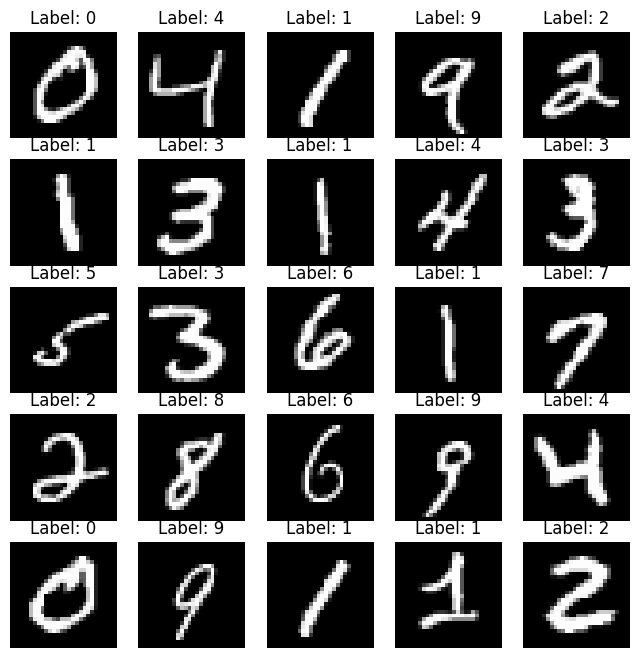

In [40]:
visualise_samples(train_data)

In [41]:
train_dataloader = DataLoader(train_data, batch_size=BATCH_SZ)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SZ)

## Building the Model

In [ ]:
class MLP(nn.Module):
    def __init__(self, hidden=512, activation_fn=nn.ReLU):
        super().__init__()

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28*28, hidden)
        self.linear2 = nn.Linear(hidden, hidden)
        self.linear3 = nn.Linear(hidden, 10)
        
        self.activation = activation_fn()

    def forward(self, x):
        x = self.flatten(x)
        x = self.activation(self.linear1(x))
        x = self.activation(self.linear2(x))
        logits = self.activation(self.linear3(x))
        return logits

In [ ]:
model = MLP().to(device)

In [ ]:
model(train_data[0][0].to(device))

## Model Optimisation

In [ ]:
# Hyperperamters
LEARNING_RATE = 1e-3
EPOCHS = 10

### Loss Function

In [ ]:
loss_fn = nn.CrossEntropyLoss()

### Optimiser

In [ ]:
optim = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)

### Training Loop

In [ ]:
def train_step(x, y, model, loss_fn, optim):
    pred = model(x)
    loss = loss_fn(pred, y)
    
    loss.backward()
    optim.step()
    optim.zero_grad()

    return loss

In [ ]:
def train_loop(dataloader, model, loss_fn, optim):
    # Training mode for batchnorm, dropout, etc.
    model.train()

    with tqdm(dataloader) as pbar:
        for x, y in pbar:
            x.to(device)
            y.to(device)
            loss = train_step(x, y, model, loss_fn, optim)
            pbar.set_postfix({'loss': f'{loss:>7f}'})

In [ ]:
def test_loop(dataloader, model, loss_fn):
    '''
    Code taken from https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
    '''
    
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for x, y in dataloader:
            x.to(device)
            y.to(device)
            pred = model(x)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## Training!!!

In [ ]:
for ep in range(EPOCHS):
    print(f"\nEpoch {ep+1}:")
    train_loop(train_dataloader, model, loss_fn, optim)
    test_loop(test_dataloader, model, loss_fn)